In [0]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [0]:
from tensorflow.keras.layers import LSTM, GRU, Dense
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import ReduceLROnPlateau, ModelCheckpoint, EarlyStopping, TensorBoard
from tensorflow.keras.optimizers import RMSprop
from sklearn.impute import SimpleImputer
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder
from matplotlib import pyplot as plt
import tensorflow as tf
import os
import random

In [0]:
os.chdir('/content/gdrive/My Drive/thesis')

In [0]:
data = pd.read_pickle('master_dataset_24112019.pkl')
data = data.dropna(how='any', axis=0)

In [0]:
rf = pd.read_pickle('rf+1.pickle')

In [0]:

r = rf.predict(data)

In [0]:
r_df = pd.DataFrame(r, index=data.index, columns=['pred_+1'])

In [0]:
data = pd.concat([data, r_df], axis=1)

In [0]:
target = pd.DataFrame()
target['1_h'] = data['dk2'].shift(-1)
features = data.iloc[0: -1, :]

In [0]:
features.columns

Index(['de', 'dk1', 'dk2', 'no2', 'se3', 'se4', 'system', 'CentralProd_dk1',
       'ElectricBoilerCon_dk1', 'ExchangeContinent_dk1',
       'ExchangeGreatBelt_dk1', 'ExchangeNordicCountries_dk1', 'GrossCon_dk1',
       'LocalPowerProd_dk1', 'NetCon_dk1', 'OnshoreWindPower_dk1',
       'SolarPowerProd_dk1', 'CentralProd_dk2', 'ElectricBoilerCon_dk2',
       'ExchangeContinent_dk2', 'ExchangeNordicCountries_dk2', 'GrossCon_dk2',
       'LocalPowerProd_dk2', 'NetCon_dk2', 'OnshoreWindPower_dk2',
       'SolarPowerProd_dk2', 'sun', 'temp', 'wind', 'hour', 'weekday',
       'Offshore_dk1', 'Offshore_dk2', 'pred_+1'],
      dtype='object')

In [0]:
features = features.drop(['SolarPowerProd_dk2', 'SolarPowerProd_dk1', 'LocalPowerProd_dk1', 'ExchangeGreatBelt_dk1', 'Offshore_dk1', 'Offshore_dk2', 'ExchangeNordicCountries_dk1', 'ExchangeNordicCountries_dk2'], axis=1)

In [0]:
target = target[:-1]

In [0]:
target_fitter = target

In [0]:
qs = [-100]
for i in range(1, 101):
  q = i
  qs.append(np.percentile(target_fitter, q))

In [0]:
new_feature = features['dk2'].copy()

In [0]:
new_feature = pd.DataFrame(new_feature, index=target.index)
new_feature.columns = ['price']

In [0]:
def is_in_range(x, lower, upper, val):
  if lower < x <= upper:
    return val
  else:
    return 0

In [0]:
def is_in_range(x, lower, upper, val):
  if lower < x <= upper:
    return val
  else:
    return 0

In [0]:
ss = dict()
for i, (lower, upper) in enumerate(zip(qs[:-1], qs[1:])):
  print(lower, upper)
  s = new_feature['price'].apply(lambda row: is_in_range(row, lower, upper, i))
  ss[i] = s

-100 24.500799999999998
24.500799999999998 57.4704
57.4704 72.7689
72.7689 84.976
84.976 97.54150000000001
97.54150000000001 111.84
111.84 123.14870000000005
123.14870000000005 133.7804
133.7804 141.88
141.88 148.28300000000002
148.28300000000002 152.6993
152.6993 157.35
157.35 161.62189999999998
161.62189999999998 165.35820000000004
165.35820000000004 169.34449999999998
169.34449999999998 173.33
173.33 176.8771
176.8771 179.78
179.78 182.88
182.88 185.656
185.656 187.83460000000002
187.83460000000002 190.79
190.79 193.69
193.69 196.2712
196.2712 199.3275
199.3275 201.79
201.79 204.76
204.76 207.49640000000005
207.49640000000005 209.56
209.56 211.89899999999997
211.89899999999997 214.16
214.16 216.06
216.06 217.88
217.88 219.75
219.75 221.56
221.56 223.24
223.24 224.69
224.69 226.47
226.47 228.3957
228.3957 230.05
230.05 231.56829999999997
231.56829999999997 233.54
233.54 235.34
235.34 237.26999999999998
237.26999999999998 238.84
238.84 240.58
240.58 242.58999999999997
242.589999999999

In [0]:
_df = pd.DataFrame(ss)

In [0]:
features['price_bin'] = _df.sum(axis=1)

In [0]:
features['price_bin'] = _df.sum(axis=1)

In [0]:
imp_mean1 = SimpleImputer(missing_values=np.nan, strategy='mean')
imp_mean1.fit(features)
imp_features = imp_mean1.transform(features)

In [0]:
import datetime

In [0]:
x_train = features[(features.index.date >= datetime.date(2012, 1, 1)) & (features.index.date < datetime.date(2013, 1, 1))]
x_test = features[(features.index.date >= datetime.date(2015, 1, 1)) & (features.index.date < datetime.date(2017, 1, 1))]

try:
  y_train = target[target.index.date >= datetime.date(2012, 1, 1) & (target.index.date < datetime.date(2013, 1, 1))]
  y_test = target[(target.index.date >= datetime.date(2015, 1, 1)) & (target.index.date < datetime.date(2017, 1, 1))]
except:
  y_train = target_fitter[(target_fitter.index.date >= datetime.date(2012, 1, 1)) & (target_fitter.index.date >= datetime.date(2013, 1, 1))]
  y_test = target_fitter[(target_fitter.index.date >= datetime.date(2015, 1, 1)) & (target_fitter.index.date < datetime.date(2017, 1, 1))]

In [0]:
x_train.shape

(8782, 27)

In [0]:
num_train = len(x_train)
num_test = len(x_test)

In [0]:
x_train = imp_mean1.transform(x_train)
x_test = imp_mean1.transform(x_test)

In [0]:
x_scaler = MinMaxScaler()
x_train_scaled = x_scaler.fit_transform(x_train)

In [0]:
x_test_scaled = x_scaler.transform(x_test)

In [0]:
y_scaler = MinMaxScaler()
y_train_scaled = y_scaler.fit_transform(y_train)
y_test_scaled = y_scaler.transform(y_test)

In [0]:
def batch_generator(batch_size, sequence_length):
    """
    Generator function for creating random batches of training data
    """
    
    num_x_signals = features.shape[1]
    num_y_signals = 2
    
    # infinite loop
    while True:
        # Allocate a new array for the batch of input signals
        x_shape = (batch_size, sequence_length, num_x_signals)
        x_batch = np.zeros(shape=x_shape, dtype=np.float16)
        
        # Allocate a new array for the batch of output signals 
        y_shape = (batch_size, sequence_length, num_y_signals)
        y_batch = np.zeros(shape=y_shape, dtype=np.float16)
        
        # Fill the batch with random sequences of data
        for i in range(batch_size):
            # Get a random start_index
            # This points somewhere in the training data
            idx = np.random.randint(num_train - sequence_length)
            
            # Copy the sequence of data starting from this index
            x_batch[i] = x_train_scaled[idx:idx+sequence_length]
            y_batch[i] = y_train_scaled[idx:idx+sequence_length]
            
        yield (x_batch, y_batch)

In [0]:
batch_size = 256
sequence_length = 24 * 7 * 4

In [0]:
generator = batch_generator(batch_size=batch_size, sequence_length=sequence_length)

In [0]:
x_batch, y_batch = next(generator)

In [0]:
x_batch.shape ,y_batch.shape

((256, 672, 27), (256, 672, 2))

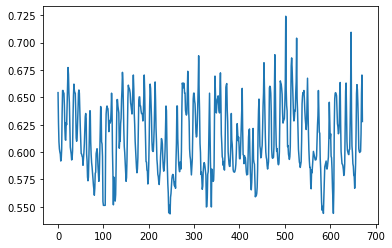

In [0]:
batch = 0 
signal = 0
seq = x_batch[batch , : , signal]
plt.plot(seq)

In [0]:
validation_data = (np.expand_dims(x_test_scaled, axis=0),
                   np.expand_dims(y_test_scaled, axis=0))

In [0]:
MODEL_NAME = '1+pred_2012'

In [0]:
model = Sequential()
model.add(LSTM(units=100,
               input_shape=(None, x_train.shape[1],),
               return_sequences=True,
               dropout=0.2,
               recurrent_dropout=0.5))
model.add(LSTM(units=30,
               return_sequences=True,
               dropout=0.2,
               recurrent_dropout=0.5))
model.add(LSTM(units=20,
               return_sequences=True,
               dropout=0.2,
               recurrent_dropout=0.5))

model.add(Dense(y_train.shape[1], activation='relu'))

In [0]:
warmup_steps = 30

In [0]:
def loss_mse_warmup(y_true, y_pred):
    """
    Calculate the mean squared error between y_true and y_pred but ignores the warmup-period of the sequence,
    as there is not yet enough data to make serious predictions.
    """
    
    # The shape of both input tensors are 
    # (batch_size, sequence_length, num_y_signals)
    
    # Ignore the warm-up period by taking slices of the tensors
    y_true_slice = y_true[: , warmup_steps: , :]
    y_pred_slice = y_pred[: , warmup_steps: , :]
    
    # The sliced tensors have the shape (batch_size, sequence_length - warmup_length, num_y_signals)
    
    # Calculate the MSE loss for each value pair
    #loss = tf.losses.mean_squared_error(y_true_slice, y_pred_slice)
    #loss = tf.losses.softmax_cross_entropy(y_true_slice, y_pred_slice)
    loss = tf.keras.losses.MSLE(y_true_slice, y_pred_slice)
    loss_mean = tf.reduce_mean(loss)
    
    return loss_mean

In [0]:
optimizer = RMSprop(lr=1e-3)

In [0]:
model.compile(loss=loss_mse_warmup, optimizer=optimizer)

In [0]:
path_checkpoint = f'/content/gdrive/My Drive/thesis/{MODEL_NAME}.keras'
callback_checkpoint = ModelCheckpoint(filepath=path_checkpoint,
                                      monitor='val_loss',
                                      verbose=1,
                                      save_weights_only=True,
                                      save_best_only=True)

callback_reduce_lr = ReduceLROnPlateau(monitor='val_loss',
                                       factor=0.1,
                                       min_lr=1e-4,
                                       patience=2,
                                       verbose=1)

callback_early_stopping = EarlyStopping(monitor='val_loss',
                                        patience=5,
                                        verbose=1)

callback_tensorboard = TensorBoard(log_dir=f'/content/gdrive/My Drive/thesis/',
                                   histogram_freq=0,
                                   write_graph=False)

In [0]:
model.fit_generator(generator=generator,
                    epochs=60,
                    steps_per_epoch=50,
                    validation_data=validation_data,
                    callbacks=[callback_checkpoint, callback_reduce_lr, callback_early_stopping, callback_tensorboard])

Epoch 1/60
 1/50 [..............................] - ETA: 5:26 - loss: 0.0277
Epoch 00001: val_loss improved from inf to 0.02768, saving model to /content/gdrive/My Drive/thesis/1+pred_2012.keras
50/50 [==============================] - 297s 6s/step - loss: 0.0052 - val_loss: 0.0277
Epoch 2/60
 1/50 [..............................] - ETA: 4:54 - loss: 0.0164
Epoch 00002: val_loss improved from 0.02768 to 0.01642, saving model to /content/gdrive/My Drive/thesis/1+pred_2012.keras
50/50 [==============================] - 292s 6s/step - loss: 0.0014 - val_loss: 0.0164
Epoch 3/60
 1/50 [..............................] - ETA: 5:00 - loss: 0.0089
Epoch 00003: val_loss improved from 0.01642 to 0.00886, saving model to /content/gdrive/My Drive/thesis/1+pred_2012.keras
50/50 [==============================] - 293s 6s/step - loss: 0.0010 - val_loss: 0.0089
Epoch 4/60
 1/50 [..............................] - ETA: 5:02 - loss: 0.0067
Epoch 00004: val_loss improved from 0.00886 to 0.00671, saving mod